# Сентимент-анализ

Анализ тональности текста (англ. Sentiment analysis) — задача компьютерной лингвистики, заключающаяся в определении эмоциональной окраски (тональности) текста и, в частности, в выявлении эмоциональной оценки авторов по отношению к объектам, описываемым в тексте

# Импортируем библиотеки

In [ ]:
# Библиотеки для работы с данными и математическими операциями
import numpy as np
import pandas as pd

# Библиотеки для визуализации
import seaborn as sns
import matplotlib.pyplot as plt

# Библиотеки для обработки текста
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.tokenize import word_tokenize
from pymystem3 import Mystem

# Загрузка дополнительных ресурсов NLTK
nltk.download('punkt')
nltk.download('stopwords')

# Библиотеки для обработки данных и моделей
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer

# Библиотеки для работы с глубоким обучением и машинным обучением
import torch
import transformers

# Утилиты
from tqdm import notebook

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Данные
#### positive.csv, negative.csv

id — уникальный номер сообщения в системе twitter.

tdate — дата публикации твита.

ttext — текст твита.

ttype — тональность твита (положительная, отрицательная).

trtw — количество ретвитов данного сообщения.

trep — количество реплаев к данному сообщению.

tfav — сколько других людей добавили это сообщение в избранное.

tstcount — число всех сообщений пользователя в сети twitter.

tfol — количество подписчиков у автора сообщения.

tfrien — количество друзей автора сообщения (те люди, которых читает пользователь).

listcount — количество листов-подписок в которые добавлен твиттер-пользователь


In [ ]:
! wget https://raw.githubusercontent.com/knapweedss/TextMining_HSE/main/sem10/data/negative.csv

--2024-06-08 08:12:06--  https://raw.githubusercontent.com/knapweedss/TextMining_HSE/main/sem10/data/negative.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21810696 (21M) [text/plain]
Saving to: ‘negative.csv’

negative.csv        100%[===================>]  20.80M  62.5MB/s    in 0.3s    

2024-06-08 08:12:06 (62.5 MB/s) - ‘negative.csv’ saved [21810696/21810696]



In [ ]:
! wget https://raw.githubusercontent.com/knapweedss/TextMining_HSE/main/sem10/data/positive.csv

--2024-06-08 08:13:01--  https://raw.githubusercontent.com/knapweedss/TextMining_HSE/main/sem10/data/positive.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23505017 (22M) [text/plain]
Saving to: ‘positive.csv’

positive.csv        100%[===================>]  22.42M  --.-KB/s    in 0.1s    

2024-06-08 08:13:01 (160 MB/s) - ‘positive.csv’ saved [23505017/23505017]



In [ ]:
! ls

negative.csv  positive.csv  sample_data


In [ ]:
pos_data = pd.read_csv('positive.csv', sep=',', on_bad_lines='skip')
neg_data = pd.read_csv('negative.csv', sep=',', on_bad_lines='skip')

In [ ]:
pos_data.head()

,id,tdate,tname,ttext,ttype,trep,trtw,tfav,tstcount,tfoll,tfrien,listcount
0,408906692374446080,1386325927,pleease_shut_up,"@first_timee хоть я и школота, но поверь, у на...",1,0,0,0,7569,62,61,0
1,408906692693221377,1386325927,alinakirpicheva,"Да, все-таки он немного похож на него. Но мой ...",1,0,0,0,11825,59,31,2
2,408906695083954177,1386325927,EvgeshaRe,RT @KatiaCheh: Ну ты идиотка) я испугалась за ...,1,0,1,0,1273,26,27,0
3,408906695356973056,1386325927,ikonnikova_21,"RT @digger2912: ""Кто то в углу сидит и погибае...",1,0,1,0,1549,19,17,0
4,408906761416867842,1386325943,JumpyAlex,@irina_dyshkant Вот что значит страшилка :D\nН...,1,0,0,0,597,16,23,1


In [ ]:
neg_data.head()

,id,tdate,tname,ttext,ttype,trep,trtw,tfav,tstcount,tfoll,tfrien,listcount
0,408906762813579264,1386325944,dugarchikbellko,на работе был полный пиддес :| и так каждое за...,-1,0,0,0,8064,111,94,2
1,408906818262687744,1386325957,nugemycejela,"Коллеги сидят рубятся в Urban terror, а я из-з...",-1,0,0,0,26,42,39,0
2,408906858515398656,1386325966,4post21,@elina_4post как говорят обещаного три года жд...,-1,0,0,0,718,49,249,0
3,408906914437685248,1386325980,Poliwake,"Желаю хорошего полёта и удачной посадки,я буду...",-1,0,0,0,10628,207,200,0
4,408906914723295232,1386325980,capyvixowe,"Обновил за каким-то лешим surf, теперь не рабо...",-1,0,0,0,35,17,34,0


# Посмотрим на данные

<ipython-input-72-74e29260c17e>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='DataFrame', y='Count',


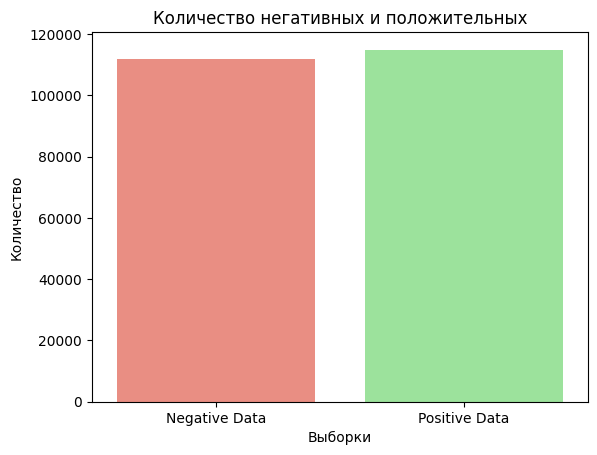

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

neg_data_len = len(neg_data)
pos_data_len = len(pos_data)

data = {
    'DataFrame': ['Negative Data', 'Positive Data'],
    'Count': [neg_data_len, pos_data_len]
}

sns.barplot(x='DataFrame', y='Count',
            data=data, palette=['salmon', 'lightgreen'])


plt.title('Количество негативных и положительных')
plt.xlabel('Выборки')
plt.ylabel('Количество')

plt.show()

Данные сбалансированы, нет сильного перевеса, поэтому можем спокойно работать дальше

# Подготовка данных

In [ ]:
neg_data['toxic'] = 0
pos_data['toxic'] = 1

In [ ]:
data = pd.concat([pos_data, neg_data]) # объединяем в 1 датасет
data.head(3)

,id,tdate,tname,ttext,ttype,trep,trtw,tfav,tstcount,tfoll,tfrien,listcount,toxic
0,408906692374446080,1386325927,pleease_shut_up,"@first_timee хоть я и школота, но поверь, у на...",1,0,0,0,7569,62,61,0,1
1,408906692693221377,1386325927,alinakirpicheva,"Да, все-таки он немного похож на него. Но мой ...",1,0,0,0,11825,59,31,2,1
2,408906695083954177,1386325927,EvgeshaRe,RT @KatiaCheh: Ну ты идиотка) я испугалась за ...,1,0,1,0,1273,26,27,0,1


In [ ]:
# оставим только трейн и таргет
data = data[['ttext', 'toxic']]

In [ ]:
# Препроцессинг
def preprocess(text, stemming=False):
    # удаляем ссылки
    text = re.sub(r'http\S+', '', text)
    # удаляем пунктуацию
    text = re.sub(r'[^\w\s]', '', text)
    # нижний регистр
    text = text.lower()
    # токенизация
    tokens = word_tokenize(text)
    # удаляем стоп-слова
    stop_words = set(stopwords.words('russian'))
    tokens = [t for t in tokens if t not in stop_words]
    # Stemming
    if stemming:
      stemmer = SnowballStemmer('russian')
      tokens = [stemmer.stem(t) for t in tokens]
    # обратно в строку
    text = ' '.join(tokens)
    return text

In [ ]:
data['ttext'] = data['ttext'].apply(preprocess)

data = data.dropna(subset=['ttext'])

Проверим на наличие дубликатов.

In [ ]:
data.duplicated().sum()

10266

Удалим дубли

In [ ]:
data = data.drop_duplicates().reset_index(drop=True)

In [ ]:
data.tail(3)

,ttext,toxic
216565,школу говно это идти,0
216566,rt _them__ lisaberoud тауриэль грусти обнял,0
216567,такси везет работу раздумываю приплатить втащи...,0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216568 entries, 0 to 216567
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   ttext   216568 non-null  object
 1   toxic   216568 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.3+ MB


# EDA, анализ фичей

In [ ]:
# кол-во символов и слов в текстах
data['symbols'] = data['ttext'].apply(len)
data['tokens'] = data['ttext'].str.split().apply(len)

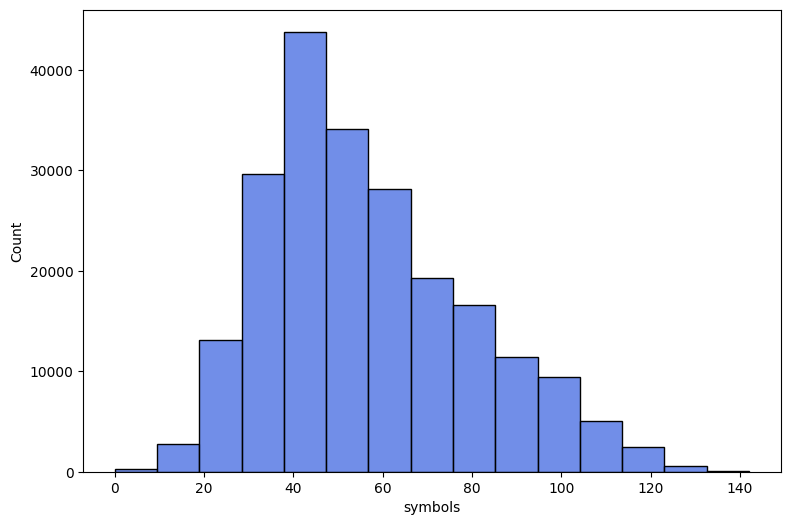

In [ ]:
plt.figure(figsize=(9, 6))
sns.histplot(x=data['symbols'], color='royalblue', bins=15)
plt.show()

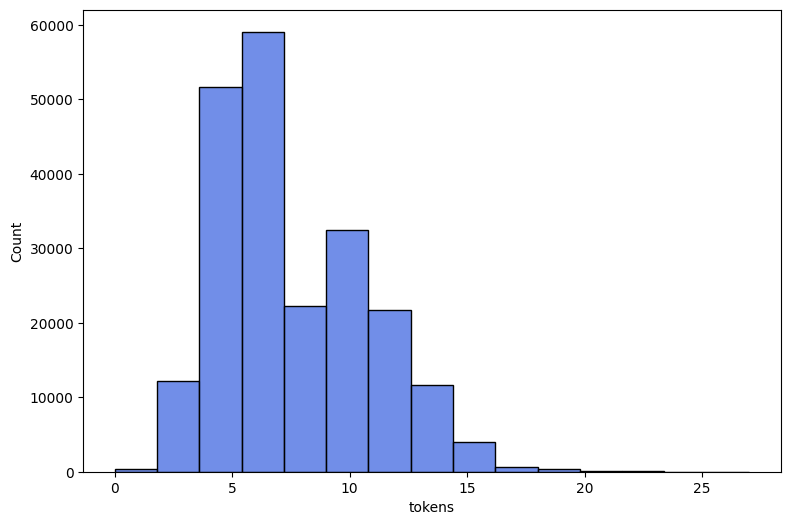

In [ ]:
plt.figure(figsize=(9, 6))
sns.histplot(x=data['tokens'], color='royalblue', bins=15)
plt.show()

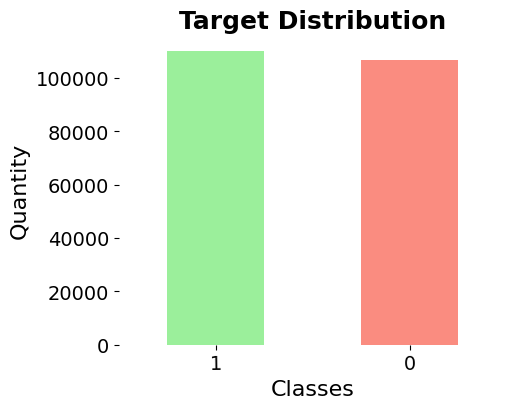

In [ ]:
fig, ax = plt.subplots(figsize=(5, 4))

# распределение таргета
data['toxic'].value_counts().plot(kind='bar', ax=ax,
                                  title='Target Distribution',
                                  xlabel='Classes',
                                  ylabel='Quantity',
                                  rot=1,
                                  color=['lightgreen' if x == 1 else 'salmon' for x in data['toxic'].value_counts().index],
                                  alpha=0.9)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.set_title('Target Distribution', fontsize=18, fontweight='bold')
ax.set_xlabel('Classes', fontsize=16)
ax.set_ylabel('Quantity', fontsize=16)
plt.show()

In [ ]:
# Удалим строки в которых всего одно слово, так как такие предложения слишком не информативны

In [ ]:
data = data[data['tokens'] > 1]

In [ ]:
data = data.drop(['symbols', 'tokens'], axis=1)

In [ ]:
data

,ttext,toxic
0,first_timee школота поверь самое d общество пр...,1
1,всетаки немного похож мальчик равно лучшеd,1
2,rt katiacheh идиотка испугалась,1
3,rt digger2912 углу сидит погибает голода ещё 2...,1
4,irina_dyshkant значит страшилка d блинпосмотре...,1
...,...,...
216563,каждый хочет исправлять,0
216564,скучаю taaannyaaa вправляет мозги равно скучаю,0
216565,школу говно это идти,0
216566,rt _them__ lisaberoud тауриэль грусти обнял,0


# Бейзлан

Перед нами задача бинарной классификации - это задача машинного обучения, в которой модель должна предсказать одну из двух возможных категорий для каждого примера

Векторизуем с помощью tf-idf, обучим логистическую регрессию


`LogisticRegression` — алгоритм машинного обучения, часто используемый для задач бинарной классификации (хотя он может быть расширен для многоклассовой классификации). В отличие от линейной регрессии, логистическая регрессия используется для моделирования вероятности принадлежности к одному из двух классов.




In [ ]:
# Разделение данных на признаки (X) и метки (y)
X = data['ttext']
y = data['toxic']

In [ ]:
# обучающая и тестовая выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Векторизация через tf-idf

In [ ]:
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Обучаем бейзлайн

In [ ]:
model = LogisticRegression()
model.fit(X_train_tfidf, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

# Предсказание и оценка

[confusion matrix - разбор](https://habr.com/ru/articles/758510/)

In [ ]:
y_pred = model.predict(X_test_tfidf)

# оценка точности
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# матрица ошибок
conf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(conf_matrix)

# отчет классификации
report = classification_report(y_test, y_pred)
print('Classification Report:')
print(report)

Accuracy: 0.7326810538246247
Confusion Matrix:
[[14797  6495]
 [ 5062 16879]]
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.69      0.72     21292
           1       0.72      0.77      0.74     21941

    accuracy                           0.73     43233
   macro avg       0.73      0.73      0.73     43233
weighted avg       0.73      0.73      0.73     43233



# Посмотрим как справится дерево решений

DecisionTreeClassifier — это один из алгоритмов машинного обучения, используемый для задач классификации. Он работает путём создания модели, которая прогнозирует значения целевой переменной, основанные на различных значениях входных признаков. Вот как он работает в деталях:

### Основные концепции

1. **Иерархическая структура**: Decision Tree представляет собой иерархическую структуру, состоящую из узлов (nodes) и ветвей (branches):
   - **Корневой узел (Root Node)**: Содержит весь набор данных и делится на два (или больше) подмножеств.
   - **Внутренние узлы (Decision Nodes)**: Узлы, где происходит разделение.
   - **Листовые узлы (Leaf Nodes)**: Конечные узлы, которые представляют собой окончательное решение или прогноз.

2. **Разделение (Splitting)**: Процесс разделения узла на два или более подузлов. Узел делится на основе функции, которая максимизирует разделение данных.

3. **Параметры разделения**: Признак и пороговое значение, используемые для разделения данных в узле. Например, если признак — это возраст, разделение может быть по линии "возраст < 30".


### Преимущества и недостатки

**Преимущества**:
- **Простота и интерпретируемость**: Decision Trees легко визуализировать и интерпретировать.
- **Могут работать как с числовыми, так и с категориальными данными**.
- **Непараметричность**: Decision Trees не делают никаких предположений о пространственном распределении данных.

**Недостатки**:
- **Склонность к переобучению**: Decision Trees могут сильно переобучаться, особенно на малых выборках.
- **Нестабильность**: Малые изменения в данных могут привести к большим изменениям в структуре дерева.
- **Предвзятость к признакам с большим числом уникальных значений**: Дерево может предпочитать признаки с большим количеством значений перед теми, которые имеют меньше уникальных значений.


In [ ]:
from sklearn.tree import DecisionTreeClassifier

# гиперпараметры стоит настраивать и подбирать оптимальные, но возьмем пока такие, чтобы обучалось не очень долго
model = DecisionTreeClassifier(max_depth=10,
                               min_samples_split=10,
                               min_samples_leaf=3,
                               max_features='sqrt', random_state=42)
model.fit(X_train_tfidf, y_train)

DecisionTreeClassifier(max_depth=10, max_features='sqrt', min_samples_leaf=3,
                       min_samples_split=10, random_state=42)

In [ ]:
y_pred = model.predict(X_test_tfidf)

# Оценка точности
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Матрица неточностей
conf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(conf_matrix)

# Отчет классификации
report = classification_report(y_test, y_pred)
print('Classification Report:')
print(report)

Accuracy: 0.5238359586427035
Confusion Matrix:
[[ 1109 20183]
 [  403 21538]]
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.05      0.10     21292
           1       0.52      0.98      0.68     21941

    accuracy                           0.52     43233
   macro avg       0.62      0.52      0.39     43233
weighted avg       0.62      0.52      0.39     43233



# Используем предобученную модель

In [ ]:
# Установка библиотеки transformers (если еще не установлена)
# !pip install transformers

In [ ]:
import pandas as pd
from transformers import pipeline

# Загрузка предобученной модели для русского языка
sentiment_model = pipeline("sentiment-analysis", model="blanchefort/rubert-base-cased-sentiment")

config.json:   0%|          | 0.00/943 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/711M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/499 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.40M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
# данных оч много, обрежем до 100 и для них предскажем
# нам здесь ничего обучать не нужно, поэтому бог с ним


# Обрезаем DataFrame до первых 100 строк
head_100 = data.head(100)

# Обрезаем DataFrame до последних 100 строк
tail_100 = data.tail(100)

data  = pd.concat([head_100, tail_100])

In [ ]:
data['predicted_label'] = data['ttext'].apply(lambda x: sentiment_model(x)[0]['label'])
data

,ttext,toxic,predicted_label
0,first_timee школота поверь самое d общество пр...,1,POSITIVE
1,всетаки немного похож мальчик равно лучшеd,1,NEUTRAL
2,rt katiacheh идиотка испугалась,1,NEUTRAL
3,rt digger2912 углу сидит погибает голода ещё 2...,1,POSITIVE
4,irina_dyshkant значит страшилка d блинпосмотре...,1,POSITIVE
...,...,...,...
216563,каждый хочет исправлять,0,NEUTRAL
216564,скучаю taaannyaaa вправляет мозги равно скучаю,0,NEGATIVE
216565,школу говно это идти,0,NEGATIVE
216566,rt _them__ lisaberoud тауриэль грусти обнял,0,NEGATIVE


In [ ]:
# Приведение меток к бинарному формату
data['predicted_binary'] = data['predicted_label'].apply(lambda x: 1 if x == 'POSITIVE' else 0)

In [ ]:
data

,ttext,toxic,predicted_label,predicted_binary
0,first_timee школота поверь самое d общество пр...,1,POSITIVE,1
1,всетаки немного похож мальчик равно лучшеd,1,NEUTRAL,0
2,rt katiacheh идиотка испугалась,1,NEUTRAL,0
3,rt digger2912 углу сидит погибает голода ещё 2...,1,POSITIVE,1
4,irina_dyshkant значит страшилка d блинпосмотре...,1,POSITIVE,1
...,...,...,...,...
216563,каждый хочет исправлять,0,NEUTRAL,0
216564,скучаю taaannyaaa вправляет мозги равно скучаю,0,NEGATIVE,0
216565,школу говно это идти,0,NEGATIVE,0
216566,rt _them__ lisaberoud тауриэль грусти обнял,0,NEGATIVE,0


In [ ]:
# оценим предсказания
accuracy = accuracy_score(data['toxic'], data['predicted_binary'])
conf_matrix = confusion_matrix(data['toxic'], data['predicted_binary'])
class_report = classification_report(data['toxic'], data['predicted_binary'])

print(f'Accuracy: {accuracy}')
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(class_report)

Accuracy: 0.58
Confusion Matrix:
[[92  8]
 [76 24]]
Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.92      0.69       100
           1       0.75      0.24      0.36       100

    accuracy                           0.58       200
   macro avg       0.65      0.58      0.53       200
weighted avg       0.65      0.58      0.53       200



Обычно в сентименте еще выделяют нейтральную тональность, в предобученной моделе оно у нас есть, но не в наших данных)
